In [2]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
#########################
######### DICTIONARIES DEFINITION 
#########################

Range_MLD = {
    'Mar' : {
        'vmin' : 160, 
        'vmax' : 1800},
    'Sep' : {
        'vmin' : 18, 
        'vmax' : 180},
}


#Colorbar parameters
color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}


# Coordinates for small regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    }
}



# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


## This dictionary is for the higher variability of the region
reg_var = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-60, -45),
        'lat' : (37, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


points = {
    'gul': {
        'lon': -60., 
        'lat': 35.
    },
    'lab': {
        'lon': -50., 
        'lat': 55.
    },
    'noe': {
        'lon': -17.5, 
        'lat': 52.5}
}


In [4]:
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


## Function to crop the dataset

def Crops(dic, coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a variable dictionary.
        
        Parameters:
        ------------
        
        dic : dictionary
            Is the dictionary from which we extract the coordinates
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = dic[coord]['lon']
    lat1, lat2 = dic[coord]['lat']
    name_fig = dic[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we are working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    ax.hist(a2, n_bins, range=ran, histtype=htype, label=label, alpha=alpha, 
            normed=normed, linewidth=lw)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [5]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)

def Point_sel(data_set, lon, lat, isel=True):
    """
        Point_sel selects a point given the latitude and longitude, or the 
        index of the array. The default function is using isel. If sel() wants
        to be used, the nearest method is used to select the point.
        
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        lon : float
            Coordinate for longitude.
        
        lat : float
            Coordinate for latitude.
        
        Output:
        ------------
        p : dataArray
            DataArray containing only the data corresponding to (lon, lat)
            
    """
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)
    

In [6]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '../../data_ARMOR/'
fl_n1 = 'ARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)
c_armor = Masking(c_armor, c_armor.to[0,25])


## Taking just MLD from the datasets

## Climatology
month_a = c_armor.groupby('time.month').mean('time')


# Let's see the Gulf Stream: Standard deviation

In [7]:
gulf = Crops(reg_ext, 'gul', c_armor)

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


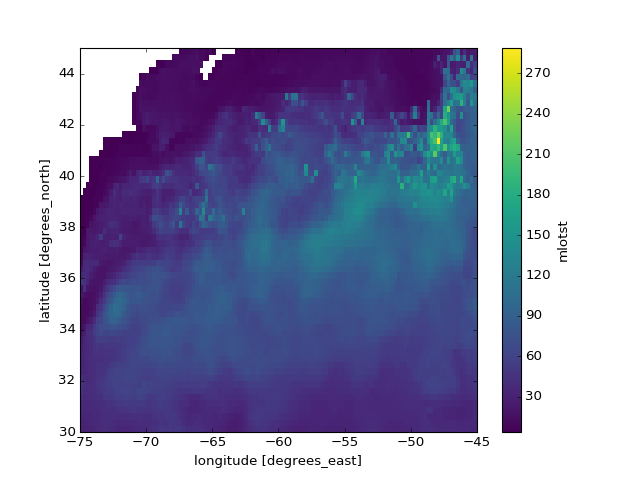

In [7]:
%matplotlib notebook

stdv = gulf.mlotst.std(dim='time')
stdv.plot()

## The region with higher variability is in (40.5N, 42.0N) (48.5W, 47.0W)

In [9]:
v = gulf.sel(longitude=slice(-50., -45.), latitude=slice(42., 45.))

In [10]:
#for lon in range(len(v.longitude.values)):
#    print(v.longitude.values[lon])

v = gulf.sel(longitude=slice(-50., -45.), latitude=slice(42., 45.))
ss = v.where(v.mask==1)

<IPython.core.display.Javascript object>


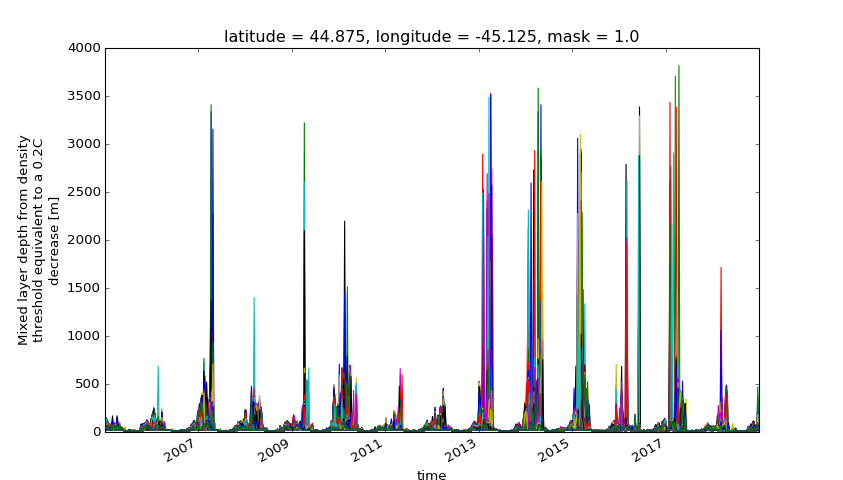

In [48]:
plt.close()
for lon in v.longitude.values:
    for lat in v.latitude.values:
        ss.mlotst.sel(longitude=lon, latitude=lat).plot()
plt.show()

In [65]:
point = gulf.sel(longitude=-65.6912, latitude=38.7079, method='nearest')
mean_p = point.groupby('time.week').mean(dim='time')
#point

In [66]:
mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

<IPython.core.display.Javascript object>


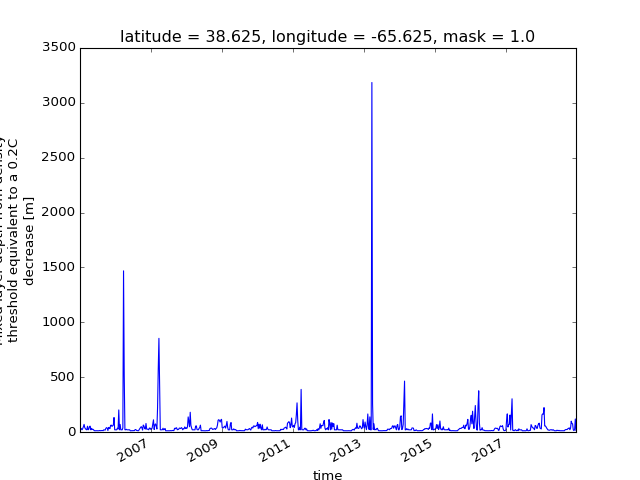

In [67]:
plt.close()
point.mlotst.plot()


<IPython.core.display.Javascript object>


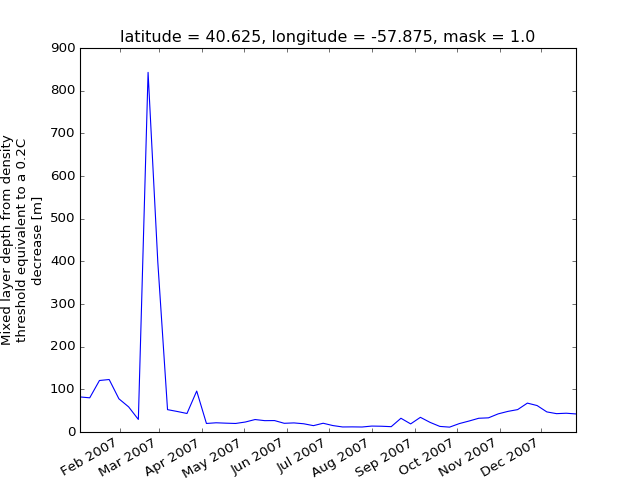

array([ 82.19995  ,  80.09985  , 120.69995  , 123.       ,  77.80005  ,
        58.899902 ,  29.399902 , 842.9      , 398.30005  ,  52.399902 ,
        48.099854 ,  43.399902 ,  96.       ,  20.       ,  21.599854 ,
        20.699951 ,  20.       ,  23.399902 ,  29.199951 ,  26.599854 ,
        26.800049 ,  20.399902 ,  21.300049 ,  19.300049 ,  14.899902 ,
        20.5      ,  15.0998535,  11.800049 ,  12.       ,  11.699951 ,
        13.899902 ,  13.5      ,  12.5      ,  32.19995  ,  19.       ,
        34.399902 ,  22.5      ,  13.0998535,  11.399902 ,  19.699951 ,
        25.699951 ,  32.19995  ,  33.19995  ,  42.5      ,  48.30005  ,
        52.5      ,  67.69995  ,  62.       ,  47.099854 ,  43.       ,
        44.       ,  42.30005  ], dtype=float32)

In [64]:
%matplotlib notebook

plt.plot()

point.mlotst.sel(time=slice('01-01-2007', '12-31-2007')).plot()
point.mlotst.sel(time=slice('01-01-2007', '12-31-2007')).values

<IPython.core.display.Javascript object>


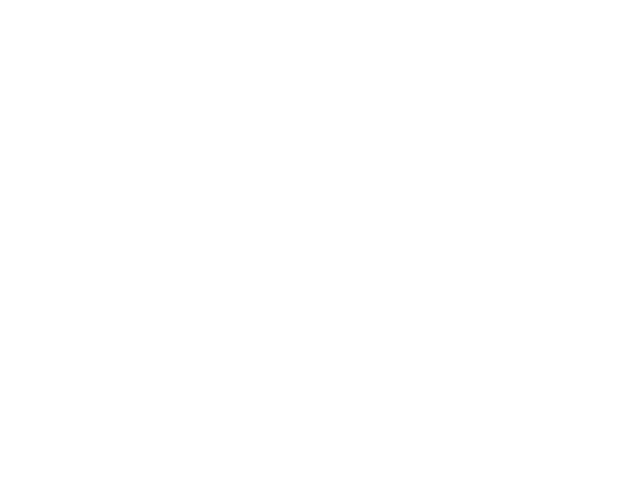

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)

KeyboardInterrupt



In [44]:
plt.close()

p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2005, 2010):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


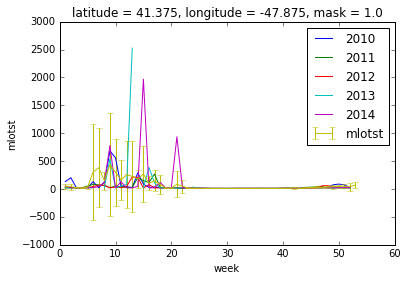

In [15]:
plt.close()

p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2010, 2015):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


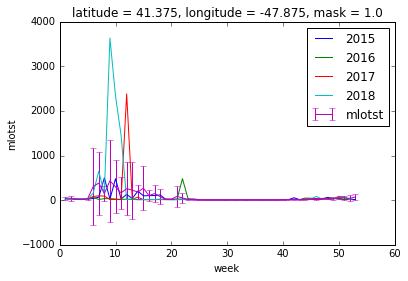

In [16]:
plt.close()

p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2015, 2019):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

## Getting the central point (50W, 42N)

In [ ]:
## The region in which I will work is the entire Gulf Stream. 

gulf = Crops(reg_ext, 'gul', c_armor)
gulf_hv = Crops(reg_var, 'gul', c_armor) ##small region
#print(gulf_hv.longitude.values, gulf.latitude.values)


In [ ]:
lon = -50.
lat = 42.
p0 = Point_sel(gulf, lon, lat, isel=False)

print(p0.longitude.values, p0.latitude.values)

In [ ]:
gulf.mlotst[0] ##lat, lon

In [ ]:
def Get_index(data_set, point):
    for la in range(len(data_set.latitude)):
        if (data_set.latitude[la].values == point.latitude.values):
            for lo in range (len(data_set.longitude)):
                 if (data_set.longitude[lo].values == point.longitude.values):
                        print(la)
                        print(lo)
                        return(lo, la)
                        break
        

In [ ]:
lonn, latt = Get_index(gulf, p0)

## Getting the points around the central point (50W, 42N)

In [ ]:
## So here, I have the coordinates of the center point p0. It is already selected
## We are going to select other 4 points arrounf the central one, in the same year
## to see how they are behaving. Also from here I should check the vertical profile.
## This points contain all years.

# index of the p0, center point
lon = p0.longitude.values
lat = p0.latitude.values
dl = 0.25

## Dataset filtered this region correspond to 
## sel(longitude=slice(-50., -45.), latitude=slice(42., 45.))

p1 = Point_sel(gulf, lon, lat+dl, isel=False)
p2 = Point_sel(gulf, lon+dl, lat, isel=False)
p3 = Point_sel(gulf, lon, lat-dl, isel=False)
p4 = Point_sel(gulf, lon-dl, lat, isel=False)

In [ ]:
p1

### Ploting all years for p1

In [ ]:
mean = p1.mlotst.groupby('time.week').mean(dim='time')
stdv = p1.mlotst.groupby('time.week').std(dim='time')

In [ ]:
plt.close()

p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2005, 2010):
    p_year= p1.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
point = p1

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2010, 2015):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2015, 2019):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

###  Point 2

In [ ]:
point = p2

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2005, 2010):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2010, 2015):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
p = np.empty(52)

plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2015, 2019):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

### Point 3

In [ ]:
point = p3

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2005, 2010):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2010, 2015):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2015, 2019):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

### Point 4

In [ ]:
point = p4

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2005, 2010):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2010, 2015):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
plt.close()
p = np.empty(52)
plt.close()
#air.isel(lon=10, lat=[19,21,22]).plot.line(x='time')
for yr in range(2015, 2019):
    p_year= point.mlotst.sel(time=point.time.dt.year.isin([yr]))
    l = str(yr)
    p_year.groupby('time.week').mean(dim='time').plot(label=l)
    p = np.append(p, p_year, axis=0)

mean = point.mlotst.groupby('time.week').mean(dim='time')
stdv = point.mlotst.groupby('time.week').std(dim='time')

plt.errorbar(mean.week, mean, yerr=stdv)

plt.legend()
plt.show()

In [ ]:
## Selecting the example year. In this case yr = 2008

p0_2008 = Year_sel(p0, 2008)
p1_2008 = Year_sel(p1, 2008)
p2_2008 = Year_sel(p2, 2008)
p3_2008 = Year_sel(p3, 2008)
p4_2008 = Year_sel(p4, 2008)

In [ ]:
p0_2008.mlotst.argmin(dim='time', skipna=True).values



In [ ]:
mxx = p0_2008.mlotst.min(skipna=True)

for i in range(len(p0_2008.time)):
    prov = p0_2008.mlotst[i]
    if prov == mxx:
        print(i)
        break

In [ ]:
print(p0_2008.longitude.values, p0_2008.latitude.values)
print(p1_2008.longitude.values, p1_2008.latitude.values)
print(p2_2008.longitude.values, p2_2008.latitude.values)
print(p3_2008.longitude.values, p3_2008.latitude.values)
print(p4_2008.longitude.values, p4_2008.latitude.values)


In [ ]:
plt.close()

p0_2008.mlotst.plot(label='center')
p1_2008.mlotst.plot(label='up')
p2_2008.mlotst.plot(label='rigth')
p3_2008.mlotst.plot(label='down')
p4_2008.mlotst.plot(label='left')

plt.legend()
plt.show()

In [ ]:
p0_2009 = Year_sel(p0, 2009)
p1_2009 = Year_sel(p1, 2009)
p2_2009 = Year_sel(p2, 2009)
p3_2009 = Year_sel(p3, 2009)
p4_2009 = Year_sel(p4, 2009)

plt.close()

p0_2009.mlotst.plot(label='ce-09')
p1_2009.mlotst.plot(label='up-09')
p2_2009.mlotst.plot(label='ri-09')
p3_2009.mlotst.plot(label='do-09')
p4_2009.mlotst.plot(label='le-09')

plt.legend()
plt.show()

In [ ]:
p0_2010 = Year_sel(p0, 2010)
p1_2010 = Year_sel(p1, 2010)
p2_2010 = Year_sel(p2, 2010)
p3_2010 = Year_sel(p3, 2010)
p4_2010 = Year_sel(p4, 2010)


plt.close()

p0_2010.mlotst.plot(label='ce-10')
p1_2010.mlotst.plot(label='up-10')
p2_2010.mlotst.plot(label='ri-10')
p3_2010.mlotst.plot(label='do-10')
p4_2010.mlotst.plot(label='le-10')

plt.legend()
plt.show()

In [ ]:
plt.close()

p0_2008.mlotst.groupby('time.week').mean(dim='time').plot(label='center')
p0_2009.mlotst.groupby('time.week').mean(dim='time').plot(label='ce-09')
p0_2010.mlotst.groupby('time.week').mean(dim='time').plot(label='ce-10')

plt.legend()
plt.show()

In [ ]:
p5_2008 = Year_sel(p5, 2008)
p5_2008.mlotst[:0,0].where(p5_2008.mask==1)

In [ ]:
#%matplotlib notebook
#plt.close()

#x = [i for i in range(0,12)]
#y = [i for i in range(0,16)]

#p5_2008.mlotst.isel(longitude=0, latitude=y).plot.line(x='time')
#plt.legend(False)
#plt.show()

### Taking just one point, looking coordinates for max value

In [ ]:
point = v.where(v.mask==1).sel(longitude=-47.83, latitude=41.29, method='nearest')
point.mlotst.plot()

In [ ]:
point.to[0].values

In [ ]:
point.depth.values

In [ ]:
maxis = point.max(dim='time', skipna=True)
maxis.mlotst.values

In [ ]:
mmm = pp.where(pp==pp.max(), drop=True).squeeze()
mmm.mlotst

In [ ]:
pp.mlotst.max()

In [ ]:
type(pp.depth)

## Making a filter for extreme values

Here, when I say 'extreme values' I refer to the values that are weirdly big. The criterion used to call them as 'extreme' is that they have to be larger than 3$\sigma$; $\sigma$ is the standard deviation. I will work over the complete North Atalntic.

In [ ]:
## From this, I will obtain the standar deviation in each grid point
## and for each week of the year. 

gulf = Crops(reg_ext, 'gul', c_armor)
stdv = gulf.groupby('time.week').std(dim='time')

In [ ]:
plt.close()
stdv.mlotst[0].plot()


In [ ]:
cond = 1*(gulf.mlotst[0] > 3.0*stdv.mlotst[0])

plt.close()
stdv.mlotst[0].where(cond==1).plot()

In [ ]:
ds_2008 = Year_sel(gulf, 2008)

cond = 1*(ds_2008.mlotst[10] > 7.*stdv.mlotst[10])

plt.close()
stdv.mlotst[10].where(cond==1).plot()

In [ ]:
for yr in range(2005, 2006):
    ds_yr = Year_sel(c_armor, yr)
    weeks = ds_yr.groupby('time.week').mean(dim='time')
    
    for w in range(len(weeks.week)):

        cond = 1*(weeks.mlotst[w] > 3.*stdv.mlotst[w])
        mask = 1 * np.ones((c_armor.dims['latitude'], c_armor.dims['longitude']) * cond
        c_armor.coords['std_m'] = (('latitude', 'longitude', 'time'), mask)


In [ ]:
cond = 1*(weeks.mlotst[2] > 3.*stdv.mlotst[2])
#mask = 1 * np.ones((c_armor.dims['latitude'], c_armor.dims['longitude'], c_armor.dims['time'])) * cond
#c_armor.coords['mask'] = (('latitude', 'longitude', 'time'), mask)
plt.close()
cond.plot()

In [ ]:
d = cond - cond1

In [ ]:
plt.close()
d.plot()
plt.show()